# Scrambling of operators

In [33]:
using Pkg
Pkg.instantiate()
using ITensors
using ITensorTDVP
using Plots
using Observers
using LinearAlgebra
using Plots.PlotMeasures

In [34]:
N  = 21    # Number of spins
J  = 1.0    # ZZ interaction strength
hx = 1.05   # X-field 
hz = 0.5    # Z-field
δt = 0.05   # Time-step for evolution
β = 0.1    # 1/temp
δβ = β/200   # temp step
T  = 5.0 # Total time
χ  = 32   # Max link dimension allowed
# hx = 0.0   # X-field 
# hz = 0.0
# Δ = 0.05
 

32

## Extended system + ancilla

In [35]:
sitesext = siteinds("S=1/2",2*N); # Make 2N S=1/2 spin indices defining system + ancilla

In [36]:
# Extract the raising, lowering and identity operators for the extended system:

Sp = ops(sitesext, [("S+", n) for n in 1:(2*N)]);  # Raising operators
Sm = ops(sitesext, [("S-", n) for n in 1:(2*N)]);  # Lowering operators
# ITensors doesn't include the identity operator as standard so construct it:
Id = Vector{ITensor}(undef,2*N)
for i =1:(2*N)
    iv = sitesext[i]
    ID = ITensor(iv', dag(iv));
    for j in 1:ITensors.dim(iv)
        ID[iv' => j, iv => j] = 1.0
    end
    Id[i] = ID
end

In [37]:
# Construct the identity vacuum state:

Ivac = MPS(sitesext, "Up") # All up spins initial state
gates = [(Id[n]*Id[n+1] + Sm[n]*Sm[n+1]) for n in 1:2:(2*N)]; # Maps |00> => |00> + |11>
Ivac = apply(gates, Ivac; cutoff=1e-15); # Note we have no 1/sqrt(2) normalisation

In [38]:
# Vectorisation approach used here is to stack matrix rows into a column vector.
# This means that:
# vec(AB) = A ⊗ I vec(B) =  I ⊗ B^T vec(A)
# so |i><j| => |i> ⊗ |j>
# vec(L A R) = L ⊗ R^T vec(A)

# Anticommutator Hamiltonian due to  e^(-βH/2) X_0 e^(-βH/2) operator
# as opposed to e^(-iHt) X_0 e^(iHt)

# HA = H ⊗ I + I ⊗ H, since H is real and hermitian H = H^T

H_op = OpSum()
for i=1:2*(N-1)
    H_op += J,"Sz",i,"Sz",i+2
end
for i=1:2*N
    H_op +=  hx,"Sx",i
    H_op +=  hz,"Sz",i
end


# Convert these terms to an MPO
HA = MPO(H_op,sitesext);

In [39]:
# Define observable for scrambling:
A_op = OpSum()
A_op += 1.0,"Sx",2*floor(Int,N/2+1)-1  # Sx operator in the middle of the system
A = MPO(A_op,sitesext);                # Build the MPO from these terms
Avec = apply(A, Ivac; cutoff=1e-15);   # Compute |A> = A|I>


function local_op(N,sitesext;r) #function used to define local operator to track C(r,t)
    # requirer < floor(Int, N/2) 
    site_index= 2*floor(Int,N/2+1)+2*r-1 #defining site index
    Sx_r_system= op("Sx", sitesext, site_index)
    Sx_r_ancilla= op("Sx", sitesext, site_index+1)
    
    return Sx_r_system, Sx_r_ancilla
end;



## Perform TDVP time evolution of the operator

In [40]:
# Define function for computing entanglement entropy

function entanglement_entropy(ψ)
# Compute the von Neumann entanglement entropy across each bond of the MPS
    N = length(ψ)
    SvN = zeros(N)
    psi = ψ
    for b=1:N
        psi = orthogonalize(psi, b)
        if b==1
            U,S,V = svd(psi[b] , siteind(psi, b))
        else
            U,S,V = svd(psi[b], (linkind(psi, b-1), siteind(psi, b)))
        end
        p = diag(S).^2               # Extract square of Schmidt coefficients
        p = p ./ sum(p)              # Normalise to a probability dist
        SvN[b] = -sum(p .* log2.(p)) # Compute Shannon entropy
    end
    return SvN
end;

# Define function that calulates the commutator 
function compute_commutator(ψ,Sx_r_system,Sx_r_ancilla)
    Sx_a= apply(Sx_r_system,ψ;cutoff=1e-15)
    a_Sx= apply(Sx_r_ancilla,ψ;cutoff=1e-15)

    return Sx_a - a_Sx
end;

In [41]:
SvN_init = entanglement_entropy(Avec);




Here $|A>$ displays the entanglement structure of the initial vacuum state.

In [42]:
# Define observer functions for TDVP:

function current_time(; current_time, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return real(-im*current_time)
  end
    
  return nothing
end

function measure_SvN(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return (entanglement_entropy(psi)-SvN_init)
  end
  return nothing
end;

function measure_linkdim(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return maxlinkdim(psi)
  end
  return nothing
end;

function measure_commutator(; psi, bond, half_sweep)
  Sx_2_system, Sx_2_ancilla= local_op(N,sitesext;r=2)
  Sx_4_system, Sx_4_ancilla= local_op(N,sitesext;r=4)
  Sx_6_system, Sx_6_ancilla= local_op(N,sitesext;r=6)
  Sx_8_system, Sx_8_ancilla= local_op(N,sitesext;r=8)

  if bond == 1 && half_sweep == 2
    commutator_2 = compute_commutator(psi, Sx_2_system, Sx_2_ancilla)
    commutator_4 = compute_commutator(psi, Sx_4_system, Sx_4_ancilla)
    commutator_6 = compute_commutator(psi, Sx_6_system, Sx_6_ancilla)
    commutator_8 = compute_commutator(psi, Sx_8_system, Sx_8_ancilla)

    return [real.(inner(commutator_2, commutator_2)), real.(inner(commutator_4, commutator_4)),
            real.(inner(commutator_6, commutator_6)), real.(inner(commutator_8, commutator_8))]

  end
  return nothing

end;

;


In [43]:
# construct Hamiltonian H
sites = siteinds("S=1/2",N)

H_op = OpSum()
for i=1:N-1
    H_op += 1.0,"Sz",i,"Sz",i+1 # ZZ terms
end
for i=1:N
    H_op +=  hx,"Sx",i         # X terms
    H_op +=  hz,"Sz",i         # Z terms
end
# Convert these terms to an MPO
H = MPO(H_op,sites)

H_squared = apply(H,H)
;

In [44]:
trace_H = tr(H)
trace_H_squared = tr(H)

Z_test = 2^N - β/2 *trace_H + β^2/4 * trace_H_squared

2.097152e6

In [45]:
# Perform imaginary time evolution on Ivac



# d|A(t)>/dt = i HC |A(t)> so |A(t)> = exp(i t HC)|A(0)> 
ψ_temp = tdvp(HA, β/2, Ivac; 
          time_step = δβ,
          normalize = false,
          maxdim = χ,
          cutoff = 1e-10,
          outputlevel=1)

# this will be the thermal state, imaginary time evolved to β/2
# Z = tr(ψ_temp)
Z = inner(Ivac, ψ_temp) 

ρ_β = ψ_temp/Z
;


After sweep 1: maxlinkdim=2 maxerr=7.94E-16 current_time=0.0 time=0.836


After sweep 2: maxlinkdim=2 maxerr=1.02E-15 current_time=0.001 time=0.784


After sweep 3: maxlinkdim=2 maxerr=1.09E-15 current_time=0.002 time=0.9


After sweep 4: maxlinkdim=2 maxerr=1.02E-15 current_time=0.002 time=0.972


After sweep 5: maxlinkdim=2 maxerr=1.13E-15 current_time=0.002 time=0.923


After sweep 6: maxlinkdim=2 maxerr=7.88E-16 current_time=0.003 time=0.953


After sweep 7: maxlinkdim=2 maxerr=7.77E-16 current_time=0.004 time=1.034


After sweep 

8: maxlinkdim=2 maxerr=9.99E-16 current_time=0.004 time=1.375


After sweep 9: maxlinkdim=2 maxerr=8.87E-16 current_time=0.005 time=1.025


After sweep 10: maxlinkdim=2 maxerr=3.32E-16 current_time=0.005 time=0.982


After sweep 11: maxlinkdim=2 maxerr=4.43E-16 current_time=0.006 time=1.09


After sweep 12: maxlinkdim=2 maxerr=9.06E-16 current_time=0.006 time=0.995


After sweep 13: maxlinkdim=2 maxerr=7.79E-16 current_time=0.007 time=1.142


After sweep 14: maxlinkdim=2 maxerr=8.02E-16 current_time=0.007 time=1.3


After sweep 15: maxlinkdim=2 maxerr=1.12E-15 current_time=0.008 time=0.878


After sweep 16: maxlinkdim=2 maxerr=8.84E-16 current_time=0.008 time=1.035


After sweep 17: maxlinkdim=2 maxerr=5.52E-16 current_time=0.009 time=0.956


After sweep 18: maxlinkdim=2 maxerr=6.63E-16 current_time=0.009 time=0.909


After sweep 19: maxlinkdim=2 maxerr=5.52E-16 current_time=0.01 time=0.829


After sweep 20: maxlinkdim=2 maxerr=6.62E-16 current_time=0.01 time=0.925


After sweep 21: maxlinkdim=2 maxerr=6.61E-16 current_time=0.011 time=0.864


After sweep 22: maxlinkdim=2 maxerr=6.61E-16 current_time=0.011 time=0.938


After sweep 23: maxlinkdim=2 maxerr=7.70E-16 current_time=0.012 time=0.965


After sweep 24: maxlinkdim=2 maxerr=9.90E-16 current_time=0.012 time=1.108


After sweep 25: maxlinkdim=2 maxerr=8.73E-16 current_time=0.013 time=1.114


After sweep 26: maxlinkdim=2 maxerr=1.12E-15 current_time=0.013 time=1.043


After sweep 27: maxlinkdim=2 maxerr=9.87E-16 current_time=0.014 time=1.042


After sweep 28: maxlinkdim=2 maxerr=1.21E-15 current_time=0.014 time=1.37


After sweep 29: maxlinkdim=2 maxerr=1.31E-15 current_time=0.015 time=1.504


After sweep 30: maxlinkdim=2 maxerr=1.31E-15 current_time=0.015 time=1.361


After sweep 31: maxlinkdim=2 maxerr=1.42E-15 current_time=0.016 time=1.651


After sweep 32: maxlinkdim=2 maxerr=1.64E-15 current_time=0.016 time=1.59


After sweep 33: maxlinkdim=2 maxerr=1.74E-15 current_time=0.017 time=1.533


After sweep 34: maxlinkdim=2 maxerr=1.94E-15 current_time=0.017 time=2.085


After sweep 35: maxlinkdim=2 maxerr=2.07E-15 current_time=0.018 time=1.53


After sweep 36: maxlinkdim=2 maxerr=2.28E-15 current_time=0.018 time=1.025


After sweep 37: maxlinkdim=2 maxerr=2.50E-15 current_time=0.019 time=1.237


After sweep 38: maxlinkdim=2 maxerr=2.71E-15 current_time=0.019 time=0.961


After sweep 39: maxlinkdim=2 maxerr=2.86E-15 current_time=0.02 time=1.026


After sweep 40: maxlinkdim=2 maxerr=3.18E-15 current_time=0.02 time=1.003


After sweep 41: maxlinkdim=2 maxerr=3.59E-15 current_time=0.021 time=0.924


After sweep 42: maxlinkdim=2 maxerr=3.83E-15 current_time=0.021 time=0.918


After sweep 43: maxlinkdim=2 maxerr=4.23E-15 current_time=0.022 time=0.9


After sweep 44: maxlinkdim=2 maxerr=4.61E-15 current_time=0.022 time=0.929


After sweep 45: maxlinkdim=2 maxerr=4.92E-15 current_time=0.023 time=1.0


After sweep 46: maxlinkdim=2 maxerr=5.37E-15 current_time=0.023 time=0.939


After sweep 47: maxlinkdim=2 maxerr=5.88E-15 current_time=0.024 time=0.816


After sweep 48: maxlinkdim=2 maxerr=6.33E-15 current_time=0.024 time=0.936


After sweep 49: maxlinkdim=2 maxerr=7.05E-15 current_time=0.025 time=1.057


After sweep 50: maxlinkdim=2 maxerr=7.44E-15 current_time=0.025 time=0.957


After sweep 51: maxlinkdim=2 maxerr=8.08E-15 current_time=0.026 time=1.001


After sweep 52: maxlinkdim=2 maxerr=8.62E-15 current_time=0.026 time=

0.847


After sweep 53: maxlinkdim=2 maxerr=9.45E-15 current_time=0.027 time=0.972


After sweep 54: maxlinkdim=2 maxerr=1.01E-14 current_time=0.027 time=0.906


After sweep 55: maxlinkdim=2 maxerr=1.08E-14 current_time=0.028 time=0.961


After sweep 56: maxlinkdim=2 maxerr=1.17E-14 current_time=0.028 time=0.886


After sweep 57: maxlinkdim=2 maxerr=1.26E-14 current_time=0.029 time=0.953


After sweep 58: maxlinkdim=2 maxerr=1.33E-14 current_time=0.029 time=1.187


After sweep 59: maxlinkdim=2 maxerr=1.43E-14 current_time=0.03 time=0.999


After sweep 60: maxlinkdim=2 maxerr=1.53E-14 current_time=0.03 time=0.984


After sweep 61: maxlinkdim=2 maxerr=1.62E-14 current_time=0.031 time=0.85


After sweep 62: maxlinkdim=2 maxerr=1.73E-14 current_time=0.031 time=1.018


After sweep 63: maxlinkdim=2 maxerr=1.86E-14 current_time=0.032 time=0.947


After sweep 64: maxlinkdim=2 maxerr=1.97E-14 current_time=0.032 time=0.884


After sweep 65: maxlinkdim=2 maxerr=2.10E-14 current_time=0.033 time=1.044


After sweep 66: maxlinkdim=2 maxerr=2.23E-14 current_time=0.033 time=1.164


After sweep 67: maxlinkdim=2 maxerr=2.37E-14 current_time=0.034 time=0.951


After sweep 68: maxlinkdim=2 maxerr=2.51E-14 current_time=0.034 time=1.197


After sweep 69: maxlinkdim=2 maxerr=2.66E-14 current_time=0.035 time=1.196


After sweep 70: maxlinkdim=2 maxerr=2.82E-14 current_time=0.035 time=1.516


After sweep 71: maxlinkdim=2 maxerr=2.98E-14 current_time=0.036 time=1.966


After sweep 72: maxlinkdim=2 maxerr=3.14E-14 current_time=0.036 time=1.757


After sweep 73: maxlinkdim=2 maxerr=3.32E-14 current_time=0.037 time=1.248


After sweep 74: maxlinkdim=2 maxerr=3.52E-14 current_time=0.037 time=1.026


After sweep 75: maxlinkdim=2 maxerr=3.70E-14 current_time=0.038 time=1.223


After sweep 76: maxlinkdim=2 maxerr=3.90E-14 current_time=0.038 time=1.221


After sweep 77: maxlinkdim=2 maxerr=4.11E-14 current_time=0.039 time=1.412


After sweep 78: maxlinkdim=2 maxerr=4.32E-14 current_time=0.039 time=1.172


After sweep 79: maxlinkdim=2 maxerr=4.54E-14 current_time=0.04 time=1.288


After sweep 80: maxlinkdim=2 maxerr=4.80E-14 current_time=0.04 time=1.035


After sweep 81: maxlinkdim=2 maxerr=5.02E-14 current_time=0.041 time=0.897


After sweep 82: maxlinkdim=2 maxerr=5.27E-14 current_time=0.041 time=0.897


After sweep 83: maxlinkdim=2 maxerr=5.52E-14 current_time=0.042 time=0.779


After sweep 84: maxlinkdim=2 maxerr=5.81E-14 current_time=0.042 time=0.803


After sweep 85: maxlinkdim=2 maxerr=6.10E-14 current_time=0.043 time=0.658


After sweep 86: maxlinkdim=2 maxerr=6.38E-14 current_time=0.043 time=0.814


After sweep 87: maxlinkdim=2 maxerr=6.67E-14 current_time=0.044 time=0.798


After sweep 88: maxlinkdim=2 maxerr=6.98E-14 current_time=0.044 time=0.698


After sweep 89: maxlinkdim=2 maxerr=7.30E-14 current_time=0.045 time=0.767


After sweep 90: maxlinkdim=2 maxerr=7.63E-14 current_time=0.045 time=0.75


After sweep 91: maxlinkdim=2 maxerr=7.97E-14 current_time=0.046 time=0.763


After sweep 92: maxlinkdim=2 maxerr=8.32E-14 current_time=0.046 time=0.804


After sweep 93: maxlinkdim=2 maxerr=8.68E-14 current_time=0.047 time=0.988


After sweep 94: maxlinkdim=2 maxerr=9.08E-14 current_time=0.047 time=0.828


After sweep 95: maxlinkdim=2 maxerr=9.48E-14 current_time=0.048 time=0.854


After sweep 96: maxlinkdim=2 maxerr=9.87E-14 current_time=0.048 time=0.832


After sweep 97: maxlinkdim=2 maxerr=1.03E-13 current_time=0.049 time=0.891


After sweep 98: maxlinkdim=2 maxerr=1.07E-13

 current_time=0.049 time=1.033
After sweep 99: maxlinkdim=2 maxerr=1.12E-13 current_time=0.05 time=0.853


After sweep 100: maxlinkdim=2 maxerr=1.16E-13 current_time=0.05 time=0.989


In [46]:
A_op = OpSum()
A_op += 1.0,"Sx",2*floor(Int,N/2+1)-1  # Sx operator in the middle of the system
A = MPO(A_op,sitesext);                # Build the MPO from these terms
Avec = apply(A, ρ_β; cutoff=1e-15)
tr_ρ = inner(Ivac,ρ_β)
#inner(ρ_β, ρ_β) * 2^N


1.0

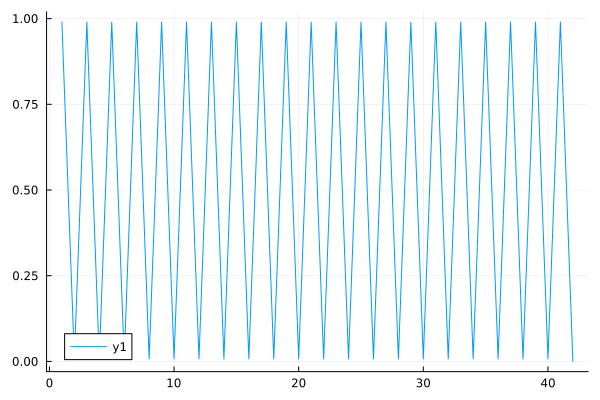

In [63]:
SvN_init = entanglement_entropy(Avec)
plot(1:2N, SvN_init)#[2:2:2N])

In [47]:
# create new HC with ψ_temp instead of Ivac
# Define "Commutator" Hamiltonian operator terms:

# HC = H ⊗ I - I ⊗ H, since H is real and hermitian H = H^T
# staggered B field to XXZ Heisenberg?
H_op = OpSum()
for i=1:2*(N-1)
    H_op += (-1)^(i-1) * J,"Sz",i,"Sz",i+2
end
for i=1:2*N
    H_op += (-1)^(i-1) * hx,"Sx",i
    H_op += (-1)^(i-1) * hz,"Sz",i
end

HC = MPO(H_op,sitesext);

In [48]:
obs = Observer("times" => current_time, "SvN" => measure_SvN, "chi" => measure_linkdim,"Commutator"=>measure_commutator)
ψf = tdvp(HC, im*T, Avec; 
          time_step = im*δt,
          normalize = false,
          maxdim = χ,
          cutoff = 1e-10,
          outputlevel=1,
          (observer!)=obs)
# Extract results from time-step observations
times=obs.times
SvN=obs.SvN
chi=obs.chi;
Commutator=obs.Commutator;

After sweep 1: maxlinkdim=4 maxerr=2.39E-11 current_time=0.0 + 0.05im time=1.786


After sweep 2: maxlinkdim=4 maxerr=7.91E-12 current_time=0.0 + 0.1im time=1.064


After sweep 3: maxlinkdim=4 maxerr=3.42E-11 current_time=0.0 + 0.15im time=0.937


After sweep 4: maxlinkdim=4 maxerr=3.82E-12 current_time=0.0 + 0.2im time=1.066


After sweep 5: maxlinkdim=4 maxerr=3.21E-11 current_time=0.0 + 0.25im time=0.902


After sweep 6: maxlinkdim=5 maxerr=5.38E-11 current_time=0.0 + 0.3im time=1.075


After sweep 7: maxlinkdim=6 maxerr=4.23E-12 current_time=0.0 + 0.35im time=0.887


After sweep 8: maxlinkdim=6 maxerr=1.21E-11 current_time=0.0 + 0.4im time=0.895


After sweep 9: maxlinkdim=6 maxerr=3.07E-11 current_time=0.0 + 0.45im time=0.954


After sweep 10: maxlinkdim=6 maxerr=7.05E-11 current_time=0.0 + 0.5im time=1.044


After sweep 11: maxlinkdim=6 maxerr=6.65E-11 current_time=0.0 + 0.55im time=0.888


After sweep 12: maxlinkdim=6 maxerr=8.62E-11 current_time=0.0 + 0.6im time=0.872


After sweep 13: maxlinkdim=6 maxerr=7.17E-11 current_time=0.0 + 0.65im time=0.982


After sweep 14: maxlinkdim=6 maxerr=9.63E-11 current_time=0.0 + 0.7im time=0.922


After sweep 15: maxlinkdim=6 maxerr=8.98E-11 current_time=0.0 + 0.75im time=1.058


After sweep 16: maxlinkdim=7 maxerr=9.33E-11 current_time=0.0 + 0.8im time=1.237


After sweep 17: maxlinkdim=8 maxerr=3.48E-11 current_time=0.0 + 0.85im time=1.233


After sweep 18: maxlinkdim=8 maxerr=5.08E-11 current_time=0.0 + 0.9im time=1.178


After sweep 19: maxlinkdim=8 maxerr=7.12E-11 current_time=0.0 + 0.95im time=1.214


After sweep 20: maxlinkdim=8 maxerr=9.72E-11 current_time=0.0 + 1.0im time=1.267


After sweep 21: maxlinkdim=8 maxerr=8.39E-11 current_time=0.0 + 1.05im time=1.144


After sweep 22: maxlinkdim=8 maxerr=5.22E-11 current_time=0.0 + 1.1im time=1.02


After sweep 23: maxlinkdim=8 maxerr=9.27E-11 current_time=0.0 + 1.15im time=1.039


After sweep 24: maxlinkdim=8 maxerr=9.18E-11 current_time=0.0 + 1.2im time=1.062


After sweep 25: maxlinkdim=8 maxerr=9.81E-11 current_time=0.0 + 1.25im time=1.152


After sweep 26: maxlinkdim=8 maxerr=8.19E-11 current_time=0.0 + 1.3im time=1.037


After sweep 27: maxlinkdim=8 maxerr=5.83E-11 current_time=0.0 + 1.35im time=1.033


After sweep 28: maxlinkdim=8 maxerr=9.09E-11 current_time=0.0 + 1.4im time=1.09


After sweep 29: maxlinkdim=8 maxerr=5.66E-11 current_time=0.0 + 1.45im time=0.985


After sweep 30: maxlinkdim=8 maxerr=9.05E-11 current_time=0.0 + 1.5im time=1.256


After sweep 31: maxlinkdim=8 maxerr=5.36E-11 current_time=0.0 + 1.55im time=1.042


After sweep 32: maxlinkdim=8 maxerr=8.20E-11 current_time=0.0 + 1.6im time=1.083


After sweep 33: maxlinkdim=8 maxerr=5.91E-11 current_time=0.0 + 1.65im time=1.025


After sweep 34: maxlinkdim=8 maxerr=8.57E-11 current_time=0.0 + 1.7im time=1.115


After sweep 35: maxlinkdim=8 maxerr=7.72E-11 current_time=0.0 + 1.75im time=1.161


After sweep 36: maxlinkdim=9 maxerr=3.92E-11 current_time=0.0 + 1.8im time=1.203


After sweep 37: maxlinkdim=9 maxerr=5.84E-11 current_time=0.0 + 1.85im time=1.293


After sweep 38: maxlinkdim=9 maxerr=8.64E-11 current_time=0.0 + 1.9im time=1.674


After sweep 39: maxlinkdim=9 maxerr=8.26E-11 current_time=0.0 + 1.95im time=1.352


After sweep 40: maxlinkdim=9 maxerr=9.93E-11 current_time=0.0 + 2.0im time=1.339


After sweep 41: maxlinkdim=10 maxerr=6.45E-11 current_time=0.0 + 2.05im time=1.278


After sweep 42: maxlinkdim=11 maxerr=5.89E-11 current_time=0.0 + 2.1im time=1.386


After sweep 43: maxlinkdim=11 maxerr=9.06E-11 current_time=0.0 + 2.15im time=1.302


After sweep 44: maxlinkdim=12 maxerr=4.88E-11 current_time=0.0 + 2.2im time=1.149


After sweep 45: maxlinkdim=12 maxerr=7.26E-11 current_time=0.0 + 2.25im time=1.302


After sweep 46: maxlinkdim=12 maxerr=9.97E-11 current_time=0.0 + 2.3im time=1.054


After sweep 47: maxlinkdim=12 maxerr=9.21E-11 current_time=0.0 + 2.35im time=1.312


After sweep 48: maxlinkdim=13 maxerr=9.42E-11 current_time=0.0 + 2.4im time=1.106


After sweep 49: maxlinkdim=14 maxerr=7.15E-11 current_time=0.0 + 2.45im time=1.245


After sweep 50: maxlinkdim=14 maxerr=5.87E-11 current_time=0.0 + 2.5im time=1.225


After sweep 51: maxlinkdim=14 maxerr=8.47E-11 current_time=0.0 + 2.55im time=1.301


After sweep 52: maxlinkdim=15 maxerr=9.49E-11 current_time=0.0 + 2.6im time=1.275


After sweep 53: maxlinkdim=15 maxerr=7.06E-11 current_time=0.0 + 2.65im time=1.147


After sweep 54: maxlinkdim=15 maxerr=9.62E-11 current_time=0.0 + 2.7im time=1.266


After sweep 55: maxlinkdim=15 maxerr=9.88E-11 current_time=0.0 + 2.75im time=1.367


After sweep 56: maxlinkdim=16 maxerr=6.16E-11 current_time=0.0 + 2.8im time=1.452


After sweep 57: maxlinkdim=16 maxerr=8.25E-11 current_time=0.0 + 2.85im time=1.35


After sweep 58: maxlinkdim=16 maxerr=8.80E-11 current_time=0.0 + 2.9im time=1.327


After sweep 59: maxlinkdim=16 maxerr=9.40E-11 current_time=0.0 + 2.95im time=1.306


After sweep 60: maxlinkdim=16 maxerr=9.84E-11 current_time=0.0 + 3.0im time=1.652


After sweep 61: maxlinkdim=17 maxerr=8.83E-11 current_time=0.0 + 3.05im time=1.505


After sweep 62: maxlinkdim=17 maxerr=8.60E-11 current_time=0.0 + 3.1im time=1.501


After sweep 63: maxlinkdim=18 maxerr=8.50E-11 current_time=0.0 + 3.15im time=1.537


After sweep 64: maxlinkdim=18 maxerr=9.96E-11 current_time=0.0 + 3.2im time=1.557


After sweep 65: maxlinkdim=19 maxerr=9.02E-11 current_time=0.0 + 3.25im time=1.535


After sweep 66: maxlinkdim=20 maxerr=8.11E-11 current_time=0.0 + 3.3im time=1.497


After sweep 67: maxlinkdim=20 maxerr=9.24E-11 current_time=0.0 + 3.35im time=1.556


After sweep 68: maxlinkdim=21 maxerr=9.51E-11 current_time=0.0 + 3.4im time=1.587


After sweep 69: maxlinkdim=21 maxerr=9.93E-11 current_time=0.0 + 3.45im time=1.554


After sweep 70: maxlinkdim=22 maxerr=9.05E-11 current_time=0.0 + 3.5im time=1.758


After sweep 71: maxlinkdim=22 maxerr=9.15E-11 current_time=0.0 + 3.55im time=1.687


After sweep 72: maxlinkdim=22 maxerr=7.89E-11 current_time=0.0 + 3.6im time=1.66


After sweep 73: maxlinkdim=23 maxerr=9.57E-11 current_time=0.0 + 3.65im time=1.782


After sweep 74: maxlinkdim=23 maxerr=9.87E-11 current_time=0.0 + 3.7im time=1.842


After sweep 75: maxlinkdim=24 maxerr=9.39E-11 current_time=0.0 + 3.75im time=1.772


After sweep 76: maxlinkdim=24 maxerr=9.87E-11 current_time=0.0 + 3.8im time=1.833


After sweep 77: maxlinkdim=25 maxerr=9.84E-11 current_time=0.0 + 3.85im time=1.66


After sweep 78: maxlinkdim=25 maxerr=8.29E-11 current_time=0.0 + 3.9im time=2.004


After sweep 79: maxlinkdim=25 maxerr=8.16E-11 current_time=0.0 + 3.95im time=2.11


After sweep 80: maxlinkdim=26 maxerr=9.53E-11 current_time=0.0 + 4.0im time=2.171


After sweep 81: maxlinkdim=26 maxerr=8.69E-11 current_time=0.0 + 4.05im time=2.193


After sweep 82: maxlinkdim=26 maxerr=9.96E-11 current_time=0.0 + 4.1im time=2.153


After sweep 83: maxlinkdim=27 maxerr=8.47E-11 current_time=0.0 + 4.15im time=2.001


After sweep 84: maxlinkdim=27 maxerr=9.97E-11 current_time=0.0 + 4.2im time=2.22


After sweep 85: maxlinkdim=27 maxerr=9.52E-11 current_time=0.0 + 4.25im time=2.111


After sweep 86: maxlinkdim=28 maxerr=9.22E-11 current_time=0.0 + 4.3im time=2.433


After sweep 87: maxlinkdim=29 maxerr=9.91E-11 current_time=0.0 + 4.35im time=2.34


After sweep 88: maxlinkdim=29 maxerr=9.60E-11 current_time=0.0 + 4.4im time=2.464


After sweep 89: maxlinkdim=30 maxerr=9.91E-11 current_time=0.0 + 4.45im time=2.589


After sweep 90: maxlinkdim=30 maxerr=9.21E-11 current_time=0.0 + 4.5im time=2.422


After sweep 91: maxlinkdim=31 maxerr=9.67E-11 current_time=0.0 + 4.55im time=2.704


After sweep 92: maxlinkdim=31 maxerr=9.03E-11 current_time=0.0 + 4.6im time=2.633


After sweep 93: maxlinkdim=32 maxerr=9.51E-11 current_time=0.0 + 4.65im time=3.056


After sweep 94: maxlinkdim=32 maxerr=9.45E-11 current_time=0.0 + 4.7im time=2.702


After sweep 95: maxlinkdim=32 maxerr=1.25E-10 current_time=0.0 + 4.75im time=3.426


After sweep 96: maxlinkdim=32 maxerr=1.67E-10 current_time=0.0 + 4.8im time=3.715


After sweep 97: maxlinkdim=32 maxerr=2.19E-10 current_time=0.0 + 4.85im time=3.555


After sweep 98: maxlinkdim=32 maxerr=2.85E-10 current_time=0.0 + 4.9im time=3.101


After sweep 99: maxlinkdim=32 maxerr=3.69E-10 current_time=0.0 + 4.95im time=2.973


After sweep 100: maxlinkdim=32 maxerr=4.75E-10 current_time=0.0 + 5.0im time=2.97


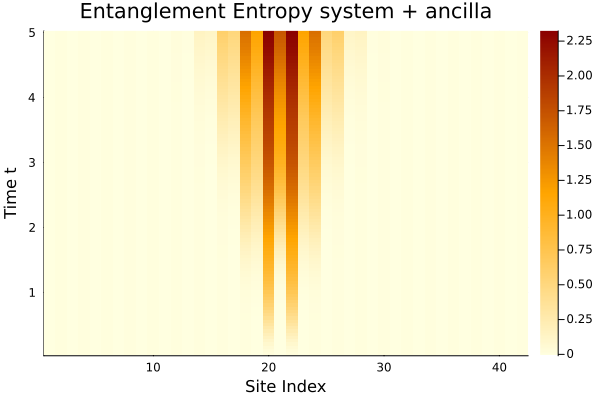

In [49]:
# Plot the entanglement entropy of each bond for system + ancilla:
gr()
heatmap(1:(2*N), times, reduce(vcat,transpose.(SvN)), c = :heat)
ylabel!("Time t")
xlabel!("Site Index")
title!("Entanglement Entropy system + ancilla")

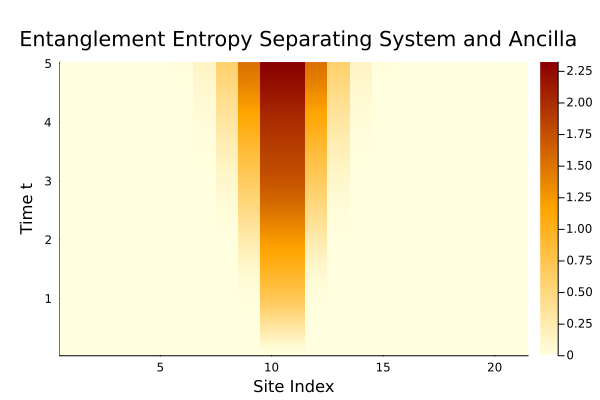

In [50]:
# Plot the entanglement entropy for bonds separating system + ancilla pairs:
gr()
S = reduce(vcat,transpose.(SvN))[:,2:2:(2*N)]
heatmap(1:N, times, S, c = :heat, left_margin=20px, top_margin = 20px)
ylabel!("Time t")
xlabel!("Site Index")
title!("\n Entanglement Entropy Separating System and Ancilla")
# a = 1
# sites_arr = range(1,N,step = 1)
# sites_arr = collect(sites_arr)
# v = J*sqrt(1-Δ^2)
# time_arr = collect(LinRange(0,T, N))
# x_τ = a.*(sites_arr.-N)/v.*time_arr
# plot!(time_arr, x_τ)

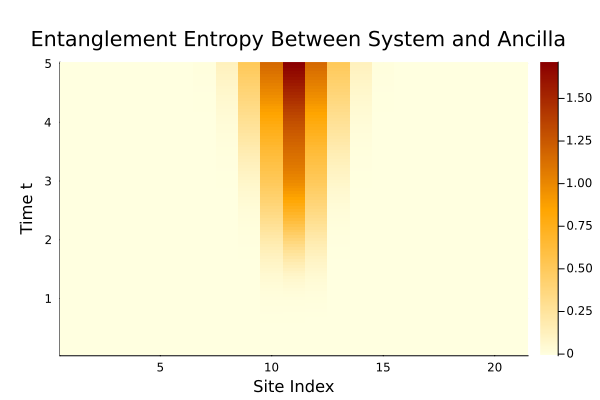

In [51]:
# Plot entanglement entropy of bonds between system + ancilla pairs:
gr()
S = reduce(vcat,transpose.(SvN))[:,1:2:(2*N)]
heatmap(1:N, times, S, c = :heat,left_margin=20px, top_margin = 20px)
ylabel!("Time t")
xlabel!("Site Index")
title!("\n Entanglement Entropy Between System and Ancilla")

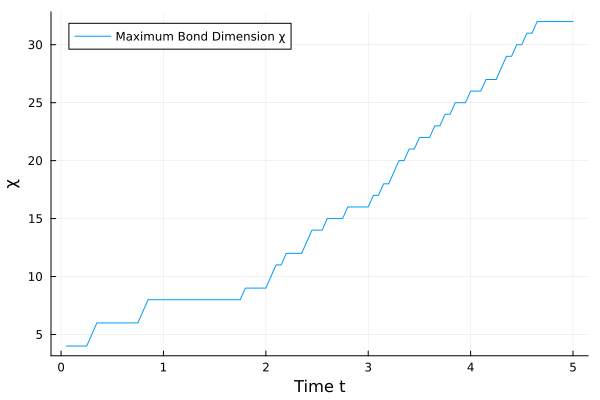

In [52]:
# Plot the growth in the maximum link dimension with time:
plot(times, chi, label="Maximum Bond Dimension χ",framstyle=:box,legend=:topleft)  
#scatter!(times, chi, label=false) 

xlabel!("Time t")
ylabel!("χ")

In [53]:
# function calculate_inner_product(Commutator_array, N)
#     #inner_product_array_5 = []
#     inner_product_array_10 = []

#     for entry in Commutator_array
        
#         #inner_product_5 = inner(entry[1], entry[1])
#         #push!(inner_product_array_5, inner_product_5)

#         inner_product_10 = inner(entry, entry) # add entry[2]
#         push!(inner_product_array_10, inner_product_10)
#     end
#     return inner_product_array_10 
# end

#Commutator is array of [real.(inner(commutator_2, commutator_2)), real.(inner(commutator_4, commutator_4)),
#                           real.(inner(commutator_6, commutator_6)), real.(inner(commutator_8, commutator_8))]
# # per timestep
C_r_t_2 = []
C_r_t_4 = []
C_r_t_6 = []
C_r_t_8 = []
for line in Commutator

    c_2 = (1/(2^N)) * line[1]
    c_4 = (1/(2^N)) * line[2]
    c_6 = (1/(2^N)) * line[3]
    c_8 = (1/(2^N)) * line[4]

    push!(C_r_t_2, c_2)
    push!(C_r_t_4, c_4)
    push!(C_r_t_6, c_6)
    push!(C_r_t_8, c_8)
end;
#C_r_t_10= (1/(2^N))*Commutator_inner_product_10



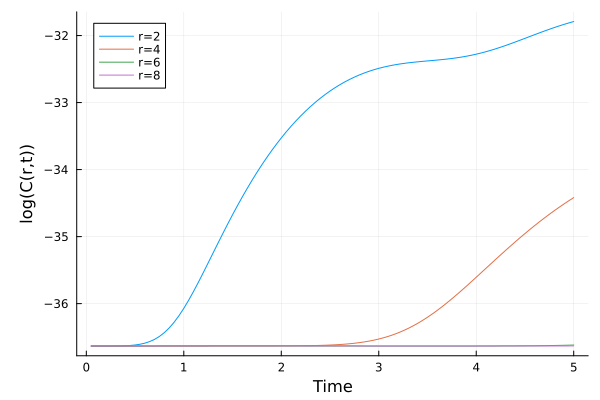

In [54]:

#min_y = -70

plot(times,log.(C_r_t_2), label="r=2", left_margin=20px)#left_margin = [5mm 0mm]) # ylim=(min_y, 20)
#scatter!(times,log.(C_r_t_2), ylim=(min_y, 20))
plot!(times,log.(C_r_t_4), label="r=4") #!
#scatter!(times,log.(C_r_t_4), ylim=(min_y, 20))
plot!(times,log.(C_r_t_6), label="r=6")
#scatter!(times,log.(C_r_t_6), ylim=(min_y, 20))
plot!(times,log.(C_r_t_8), label="r=8")
#scatter!(times,log.(C_r_t_8), ylim=(min_y, 20))

xlabel!("Time")
ylabel!("log(C(r,t))")

